In [307]:
# Import necessary libraries
import random
import os
os.chdir("C:/Users/Pauli/OneDrive/Dokumente/Uni/Masterarbeit/code/preprocessing")
import pandas as pd
import numpy as np
import pickle
#nn modules
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader
#metrics and plotting
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
#other
from earlystopper import EarlyStopper
import copy

# set up decimal display options
np.set_printoptions(precision=3)
pd.options.display.precision = 3

# global random seed
random.seed(42)
np.random.seed(42)
torch.random.manual_seed(42)

Choose which Features are used as Input

In [308]:
# choose which feature set to use ligands either mordred or morgan fingerprints and kinases either ascii or propy features
feature_set_ligand = "Morgan_Fingerprints" # "Mordred_Features" or "Morgan_Fingerprints" or None for ligands   !! None doesnt work yet !!
feature_set_kinase = None   # "ascii" [or "Sequences_propy" or "Pocket_Sequences_propy"] or None for kinases !! None doesnt work yet !!


Load the Data

In [309]:
#load necessary data
#open multi index pickle file
with open("data_split_multiind.pkl", "rb") as f:
    [ind_train, ind_val, ind_test, ind_holdout] = pickle.load(f)

#Load Kinase-ligand-K_off dataset
df_target_value = pd.read_excel("kinase_ligand_k_off.xlsx", sheet_name='kinase_ligand_k_off')
df_target_value = df_target_value.dropna(subset=["log_koff"])  #drop rows with missing target value

#set feature_range for scalers if mordred
if feature_set_ligand == "Mordred_Features":
    feature_range = (-1, 1)
else:
    feature_range = (0, 1)

#prepare feature dataframe
if feature_set_ligand and feature_set_kinase:
    df_ligand = pd.read_excel("ligand_and_kinase_features_data.xlsx", sheet_name="Ligand_"+feature_set_ligand)
    df_kinase = pd.read_excel("ligand_and_kinase_features_data.xlsx", sheet_name="Kinase_"+feature_set_kinase)
    df = pd.merge(df_target_value, df_ligand, on="ligand", how="left") 
    df_all = pd.merge(df, df_kinase, on="kinase", how="left")   
elif feature_set_ligand:
    df_ligand = pd.read_excel("ligand_and_kinase_features_data.xlsx", sheet_name="Ligand_"+feature_set_ligand)
    df_all = pd.merge(df_target_value, df_ligand, on="ligand", how="left") 
elif feature_set_kinase:
    df_kinase = pd.read_excel("ligand_and_kinase_features_data.xlsx", sheet_name="Kinase_"+feature_set_kinase)
    df_all = pd.merge(df_target_value, df_kinase, on="kinase", how="left")
else:
    raise ValueError("At least one feature set must be selected.")

    
df_all.dropna(subset=["log_koff"], inplace=True)  #drop rows with missing target value

#get iris split from my cleaned data set
df_train = df_all[df_all.set_index(["kinase", "ligand"]).index.isin(ind_train)].copy()
df_val = df_all[df_all.set_index(["kinase", "ligand"]).index.isin(ind_val)].copy()
df_test= df_all[df_all.set_index(["kinase", "ligand"]).index.isin(ind_test)].copy()
df_holdout = df_all[df_all.set_index(["kinase", "ligand"]).index.isin(ind_holdout)].copy()
#merge train and val for final training
#df_train = pd.merge(df_train, df_val, how="outer")

In [310]:
ligand_selectors = {
    "Mordred_Features":      lambda df: df.loc[:, "ABC":"mZagreb2"],
    "Morgan_Fingerprints":   lambda df: df.loc[:, "morgan__0":"morgan__2047"],
    None:                    lambda df: df.iloc[:, 0:0],  # empty
}

kinase_selectors = {
    "ascii":                     lambda df: df.loc[:, "0":"84"],          # columns named "0".."84"
    "Sequences_propy":           lambda df: df.loc[:, "AAC":"APAAC"],
    "Pocket_Sequences_propy":    lambda df: df.loc[:, "AAC":"APAAC"],
    None:                        lambda df: df.iloc[:, 0:0],  # empty
}

In [311]:
ligand_cols = ligand_selectors[feature_set_ligand](df_train).columns.tolist()
kinase_cols = kinase_selectors[feature_set_kinase](df_train).columns.tolist()

Feature Scaling

In [312]:
from sklearn.preprocessing import MinMaxScaler
#features
X_ligand_train = df_train[ligand_cols].apply(pd.to_numeric, errors="coerce").fillna(0).values
X_kinase_train = df_train[kinase_cols].apply(pd.to_numeric, errors="coerce").fillna(0).values
#target value
y_raw = df_train["log_koff"].values.reshape(-1, 1)
#independet scalers
x_scaler_ligand = MinMaxScaler(feature_range)
x_scaler_kinase = MinMaxScaler(feature_range)
y_scaler = MinMaxScaler(feature_range)

#fit scalers
y_scaler.fit(y_raw)

if feature_set_ligand and feature_set_kinase:
    x_scaler_ligand.fit(X_ligand_train) 
    x_scaler_kinase.fit(X_kinase_train)
elif feature_set_ligand:
    x_scaler_ligand.fit(X_ligand_train) 
    x_scaler_kinase.fit(X_ligand_train)
else:
    x_scaler_kinase.fit(X_kinase_train)
    x_scaler_ligand.fit(X_kinase_train)



 



Prepare Tensors

In [313]:
#function to prepare tensors from dataframe
def prepare_tensors(df, ligand_cols, kinase_cols, y_scaler, x_scaler_ligand, x_scaler_kinase):
    y = (df["log_koff"].values).reshape(-1, 1)
    y_scaled = y_scaler.transform(y)
    if feature_set_ligand == "Morgan_Fingerprints" and feature_set_kinase: #morgan fingerprints dont need to be scaled
        X_ligand = df[ligand_cols].apply(pd.to_numeric, errors="coerce").fillna(0).values
        X_kinase = df[kinase_cols].apply(pd.to_numeric, errors="coerce").fillna(0).values
        X_scaled_kinase = x_scaler_kinase.transform(X_kinase)
        X = np.hstack([X_scaled_kinase, X_ligand])
        print("Using unscaled Morgan Fingerprints for ligands.")
    elif feature_set_ligand and feature_set_kinase:
        X_ligand = df[ligand_cols].apply(pd.to_numeric, errors="coerce").fillna(0).values
        X_kinase = df[kinase_cols].apply(pd.to_numeric, errors="coerce").fillna(0).values
        X_scaled_kinase = x_scaler_kinase.transform(X_kinase)
        X_scaled_ligand = x_scaler_ligand.transform(X_ligand)
        X = np.hstack([X_scaled_kinase, X_scaled_ligand])
    elif feature_set_ligand == "Morgan_Fingerprints":
        X = df[ligand_cols].apply(pd.to_numeric, errors="coerce").fillna(0).values
        print("Using unscaled Morgan Fingerprints for ligands and no kinase features.")
    elif feature_set_ligand:
        X_ligand = df[ligand_cols].apply(pd.to_numeric, errors="coerce").fillna(0).values
        X= x_scaler_ligand.transform(X_ligand)
    else:
        X_kinase = df[kinase_cols].apply(pd.to_numeric, errors="coerce").fillna(0).values
        X = x_scaler_kinase.transform(X_kinase)


    X_tensor = torch.tensor(X, dtype=torch.float32) # Konvertieren in Tensoren
    y_tensor = torch.tensor(y_scaled, dtype=torch.float32)
    return TensorDataset(X_tensor, y_tensor)


# Split des Datensets in test und training data. Hhange former holdout to the final test set, change former test set to validation set
train_ds = prepare_tensors(df_train, kinase_cols=kinase_cols, ligand_cols=ligand_cols, y_scaler=y_scaler, x_scaler_kinase=x_scaler_kinase, x_scaler_ligand=x_scaler_ligand)
test_ds = prepare_tensors(df_test, kinase_cols=kinase_cols, ligand_cols=ligand_cols, y_scaler=y_scaler, x_scaler_kinase=x_scaler_kinase, x_scaler_ligand=x_scaler_ligand) #rename former test to val
val_ds = prepare_tensors(df_val, kinase_cols=kinase_cols, ligand_cols=ligand_cols, y_scaler=y_scaler, x_scaler_kinase=x_scaler_kinase, x_scaler_ligand=x_scaler_ligand) #rename former holdout to test
holdout_ds = prepare_tensors(df_holdout, kinase_cols=kinase_cols, ligand_cols=ligand_cols, y_scaler=y_scaler, x_scaler_kinase=x_scaler_kinase, x_scaler_ligand=x_scaler_ligand)

#create minibatches of the specified size
train_loader = DataLoader(train_ds, batch_size=32, shuffle=True)
val_loader = DataLoader(val_ds, batch_size=32, shuffle=False)
test_loader = DataLoader(test_ds, batch_size=32, shuffle=False)

#how to access the tensor shapes if needed
X_tensor = train_ds.tensors[0]
y_tensor = train_ds.tensors[1]
X_test = test_ds.tensors[0]
y_test = test_ds.tensors[1]


Using unscaled Morgan Fingerprints for ligands and no kinase features.
Using unscaled Morgan Fingerprints for ligands and no kinase features.
Using unscaled Morgan Fingerprints for ligands and no kinase features.
Using unscaled Morgan Fingerprints for ligands and no kinase features.


In [314]:
#Training on the original data
dropout_ratio=0.3
class NN_regression(nn.Module):
    def __init__(self, in_len, out_len=1, dropout_ratio=dropout_ratio):
        super().__init__()
        self.dropout1 = nn.Dropout(dropout_ratio)
        self.layer1   = nn.Linear(in_len, 256)
        self.dropout2 = nn.Dropout(dropout_ratio)
        self.layer2   = nn.Linear(256, 128)
        self.output   = nn.Linear(128, out_len)

    def forward(self, x):
        x = self.dropout1(x)
        x = F.relu(self.layer1(x))
        x = self.dropout2(x)
        x = F.relu(self.layer2(x))
        return self.output(x)

#training
device = torch.device("cuda" if torch.cuda.is_available() else "cpu") #use GPU if available
model = NN_regression(in_len=X_tensor.shape[1]).to(device) #size of the input layer
optimizer = torch.optim.Adam(model.parameters(), lr=0.001) #default learning rate is 0.001
loss_fn = nn.MSELoss()

#training Loop
n_epochs = 100
train_losses, val_losses = [], []  # Liste zur Speicherung der avg_loss pro Epoche

#early stopper
early_stopper = EarlyStopper(patience=20, min_delta=0.0001) #standard min_delta is 0.001
best_weights = copy.deepcopy(model.state_dict()) #save initial weights
best_val_loss = float('inf') #initialize best val loss to infinity


print(f"Training on ligand features:{feature_set_ligand} and kinase features: {feature_set_kinase}")

for epoch in range(n_epochs):
    model.train()
    total_loss = 0

    for xb, yb in train_loader:
        xb, yb = xb.to(device), yb.to(device)  # Move data to the appropriate device for GPU training
        pred = model(xb)
        loss = loss_fn(pred, yb)
        optimizer.zero_grad() #zero the parameter gradients
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    avg_loss = total_loss / len(train_loader)
    train_losses.append(avg_loss)  # Loss speichern


     # validierung
    model.eval()
    val_loss = 0
    with torch.no_grad():
        for xb, yb in val_loader:
            xb, yb = xb.to(device), yb.to(device)  # Move data to the appropriate device for GPU training
            pred = model(xb)
            loss = loss_fn(pred, yb)
            val_loss += loss.item()
    avg_val_loss = val_loss / len(val_loader)
    val_losses.append(avg_val_loss)
    
    #track best model weights
    if avg_val_loss < best_val_loss: #-early_stopper.min_delta:
        best_val_loss = avg_val_loss
        best_weights = copy.deepcopy(model.state_dict())

    print(f"Epoch {epoch+1}/{n_epochs}, Train Loss: {avg_loss:.4f}")
    
    #early stopping check
    #if early_stopper.early_stop(avg_val_loss):
     #   print(f"Early stopping triggered at epoch {epoch+1}.")
      #  break
#load best model weights after training
model.load_state_dict(best_weights)

# FINAL TEST EVALUATION (once)
model.eval()
test_loss = 0.0
with torch.no_grad():
    for xb, yb in test_loader:
        xb, yb = xb.to(device), yb.to(device)
        pred = model(xb)
        test_loss += loss_fn(pred, yb).item()
avg_test_loss = test_loss / len(test_loader)
print(f"Final TEST loss: {avg_test_loss:.4f}")


Training on ligand features:Morgan_Fingerprints and kinase features: None
Epoch 1/100, Train Loss: 0.0692
Epoch 2/100, Train Loss: 0.0258
Epoch 3/100, Train Loss: 0.0242
Epoch 4/100, Train Loss: 0.0251
Epoch 5/100, Train Loss: 0.0251
Epoch 6/100, Train Loss: 0.0231
Epoch 7/100, Train Loss: 0.0245
Epoch 8/100, Train Loss: 0.0230
Epoch 9/100, Train Loss: 0.0234
Epoch 10/100, Train Loss: 0.0225
Epoch 11/100, Train Loss: 0.0217
Epoch 12/100, Train Loss: 0.0214
Epoch 13/100, Train Loss: 0.0205
Epoch 14/100, Train Loss: 0.0207
Epoch 15/100, Train Loss: 0.0217
Epoch 16/100, Train Loss: 0.0203
Epoch 17/100, Train Loss: 0.0197
Epoch 18/100, Train Loss: 0.0211
Epoch 19/100, Train Loss: 0.0194
Epoch 20/100, Train Loss: 0.0201
Epoch 21/100, Train Loss: 0.0213
Epoch 22/100, Train Loss: 0.0197
Epoch 23/100, Train Loss: 0.0192
Epoch 24/100, Train Loss: 0.0201
Epoch 25/100, Train Loss: 0.0186
Epoch 26/100, Train Loss: 0.0191
Epoch 27/100, Train Loss: 0.0191
Epoch 28/100, Train Loss: 0.0182
Epoch 29/10

Finished Training on ligand features: Morgan_Fingerprints and kinase features: None

Test MSE: 0.7030 |Test R²: 0.0715 | Train R²: 0.2185 | Val R²: 0.1353| Holdout R2: -0.0979 | best epoch 73


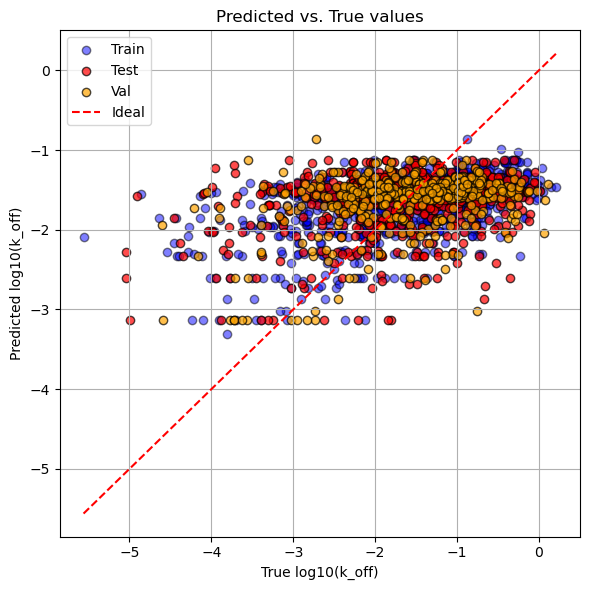

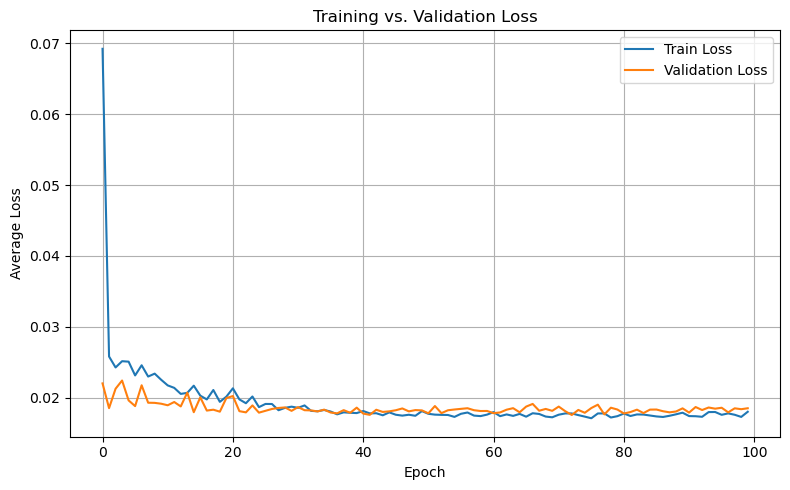

In [315]:

# evaluierung
model.eval()
with torch.no_grad():
    #test predictions

    y_test_pred_scaled = model(test_ds.tensors[0]).numpy()
    y_test_pred = y_scaler.inverse_transform(y_test_pred_scaled)
    y_test_true = y_scaler.inverse_transform(test_ds.tensors[1].numpy())

    # Train Predictions
    y_train_pred_scaled = model(train_ds.tensors[0]).numpy()
    y_train_pred = y_scaler.inverse_transform(y_train_pred_scaled)
    y_train_true = y_scaler.inverse_transform(train_ds.tensors[1].numpy())
    
    #validation predictions
    y_val_pred_scaled=model(val_ds.tensors[0]).numpy()
    y_val_pred = y_scaler.inverse_transform(y_val_pred_scaled)
    y_val_true = y_scaler.inverse_transform(val_ds.tensors[1].numpy())
    
    #validation predictions
    y_holdout_pred_scaled=model(holdout_ds.tensors[0]).numpy()
    y_holdout_pred = y_scaler.inverse_transform(y_holdout_pred_scaled)
    y_holdout_true = y_scaler.inverse_transform(holdout_ds.tensors[1].numpy())
    
    


mse = mean_squared_error(y_test_true, y_test_pred)
r2 = r2_score(y_test_true, y_test_pred)
r2_train = r2_score(y_train_true, y_train_pred)
r2_val = r2_score(y_val_true, y_val_pred)
r2_holdout = r2_score(y_holdout_true, y_holdout_pred)

print(f"Finished Training on ligand features: {feature_set_ligand} and kinase features: {feature_set_kinase}")
print(f"\nTest MSE: {mse:.4f} |Test R²: {r2:.4f} | Train R²: {r2_train:.4f} | Val R²: {r2_val:.4f}| Holdout R2: {r2_holdout:.4f} | best epoch { np.argmin(val_losses) + 1}")

#scatter plot of predicted vs true values
plt.figure(figsize=(6, 6))
plt.scatter(y_train_true, y_train_pred, alpha=0.5, label='Train', color='blue', edgecolors='k')
plt.scatter(y_test_true, y_test_pred, alpha=0.7, label='Test', c='red', edgecolors='k')
plt.scatter(y_val_true, y_val_pred,  alpha=0.7, label='Val', c='orange', edgecolors='k')
min_val = min(y_train_true.min(), y_test_true.min())
max_val = max(y_train_true.max(), y_test_true.max())
plt.plot([min_val, max_val], [min_val, max_val], 'r--', label='Ideal')
plt.xlabel("True log10(k_off)")
plt.ylabel("Predicted log10(k_off)")
plt.title("Predicted vs. True values")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


#plot der training + validation losse

plt.figure(figsize=(8, 5))
plt.plot(train_losses, label="Train Loss", color="tab:blue")
plt.plot(val_losses, label="Validation Loss", color="tab:orange")
plt.xlabel("Epoch")
plt.ylabel("Average Loss")
plt.title("Training vs. Validation Loss")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()